## Part B: Naïve Bayes 

In [26]:
import numpy as np
import pandas as pd
from typing import Dict, List
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## B1. Dataset and Setup

In [27]:
# Download from UCI Machine Learning Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Column names
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

In [28]:
# Load data
df = pd.read_csv(url, names=column_names, na_values=" ?", skipinitialspace=True)

In [29]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [30]:
# Select only categorical features for this analysis
categorical_features = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country"
]

In [31]:
# Keep only categorical features and target
df = df[categorical_features + ["income"]].copy()

In [32]:
df

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...
32556,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,<=50K
32557,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K
32558,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States,<=50K
32559,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States,<=50K


In [33]:
# Handle missing values by treating them as a separate 'MISSING' category
for col in categorical_features:
    df[col] = df[col].astype(str)
    df[col] = df[col].fillna("MISSING")

In [34]:
# Encode target variable: 0 for <=50K, 1 for >50K
df["income"] = df["income"].str.strip()
class_map = {"<=50K": 0, ">50K": 1}
df["income"] = df["income"].map(class_map)

In [36]:
print(f"Dataset shape: {df.shape}")
print(f"Features: {', '.join(categorical_features)}")
df.head(10)

Dataset shape: (32561, 9)
Features: workclass, education, marital-status, occupation, relationship, race, sex, native-country


,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,0
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,0
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,0
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,0
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,0
5,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States,0
6,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,Jamaica,0
7,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,1
8,Private,Masters,Never-married,Prof-specialty,Not-in-family,White,Female,United-States,1
9,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,1


In [37]:
# Encode categorical features as integer codes while maintaining interpretability
feature_value_maps: Dict[str, Dict[str, int]] = {}
encoded_X = pd.DataFrame(index=df.index)

In [38]:
for col in categorical_features:
    # Create mapping: category -> integer code
    value_to_int = {v: i for i, v in enumerate(sorted(set(df[col].tolist())))}
    feature_value_maps[col] = value_to_int
    encoded_X[col] = df[col].map(value_to_int).astype(int)


In [41]:
# Separate features and target
X = encoded_X.values
y = df["income"].astype(int).values

In [42]:
print(f"Encoded feature matrix shape: {X.shape}")
print("\nSample of encoded data:")
encoded_X.head()

Encoded feature matrix shape: (32561, 8)

Sample of encoded data:


,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,7,9,4,1,1,4,1,39
1,6,9,2,4,0,4,1,39
2,4,11,0,6,1,4,1,39
3,4,1,2,6,0,2,1,39
4,4,9,2,10,5,2,0,5


In [43]:
# 70% train, 30% temp (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=RANDOM_STATE
)

In [44]:
# 50% val, 50% test (stratified)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

In [45]:
print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Train set: (22792, 8)
Validation set: (4884, 8)
Test set: (4885, 8)


In [46]:
# Analyze class distributions 
print("\nClass Distribution:")
train_counts = Counter(y_train)
val_counts = Counter(y_val)
test_counts = Counter(y_test)
print(f"Train - {{0: {train_counts[0]}, 1: {train_counts[1]}}} (Total: {len(y_train)})")
print(f"Val   - {{0: {val_counts[0]}, 1: {val_counts[1]}}} (Total: {len(y_val)})")
print(f"Test  - {{0: {test_counts[0]}, 1: {test_counts[1]}}} (Total: {len(y_test)})")


Class Distribution:
Train - {0: 17303, 1: 5489} (Total: 22792)
Val   - {0: 3708, 1: 1176} (Total: 4884)
Test  - {0: 3709, 1: 1176} (Total: 4885)


In [47]:
# Calculate and display class proportions
print("\nClass Proportions:")
print(f"Train - Class 0: {train_counts[0]/len(y_train)*100:.1f}%, Class 1: {train_counts[1]/len(y_train)*100:.1f}%")
print(f"Val   - Class 0: {val_counts[0]/len(y_val)*100:.1f}%, Class 1: {val_counts[1]/len(y_val)*100:.1f}%")
print(f"Test  - Class 0: {test_counts[0]/len(y_test)*100:.1f}%, Class 1: {test_counts[1]/len(y_test)*100:.1f}%")


Class Proportions:
Train - Class 0: 75.9%, Class 1: 24.1%
Val   - Class 0: 75.9%, Class 1: 24.1%
Test  - Class 0: 75.9%, Class 1: 24.1%


<Figure size 1000x500 with 0 Axes>

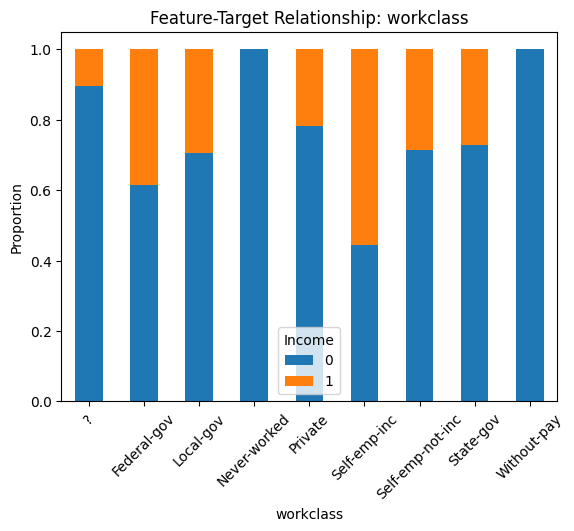

<Figure size 1000x500 with 0 Axes>

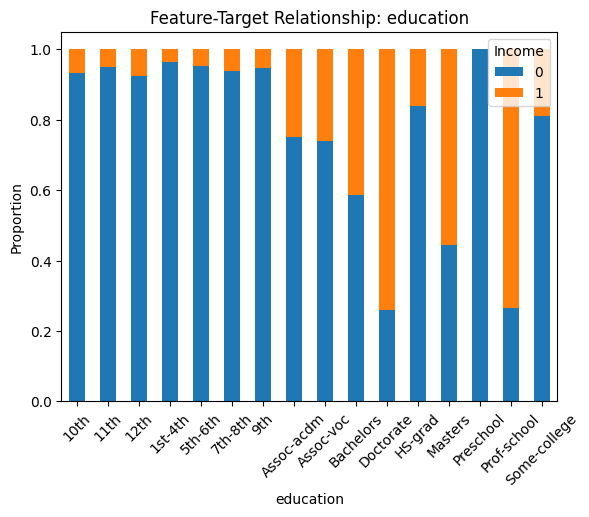

<Figure size 1000x500 with 0 Axes>

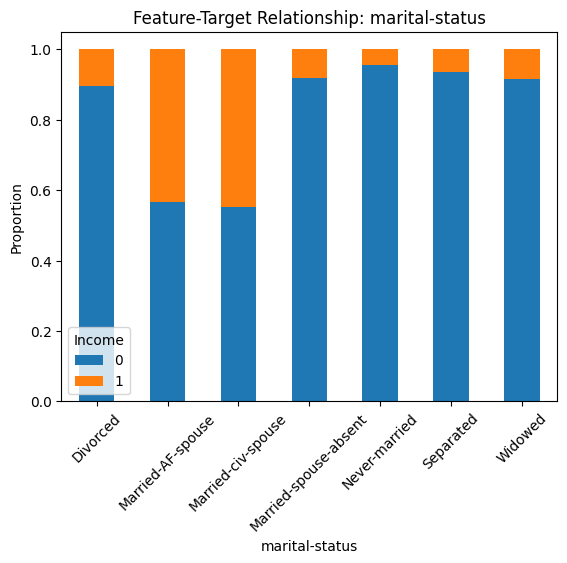

<Figure size 1000x500 with 0 Axes>

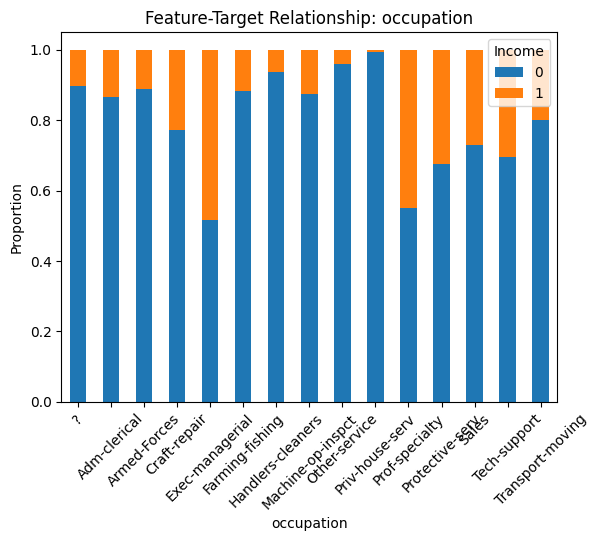

<Figure size 1000x500 with 0 Axes>

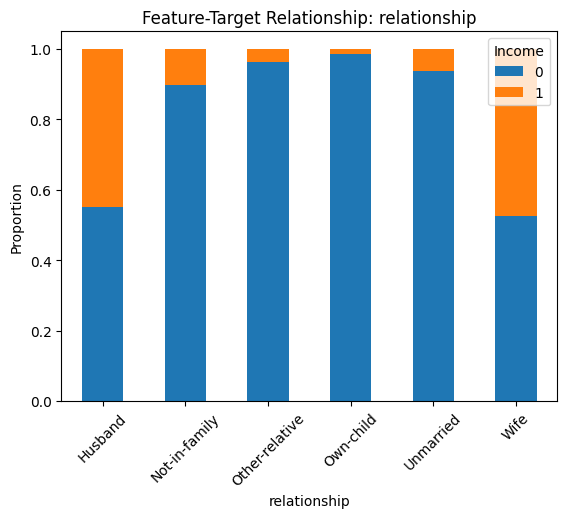

<Figure size 1000x500 with 0 Axes>

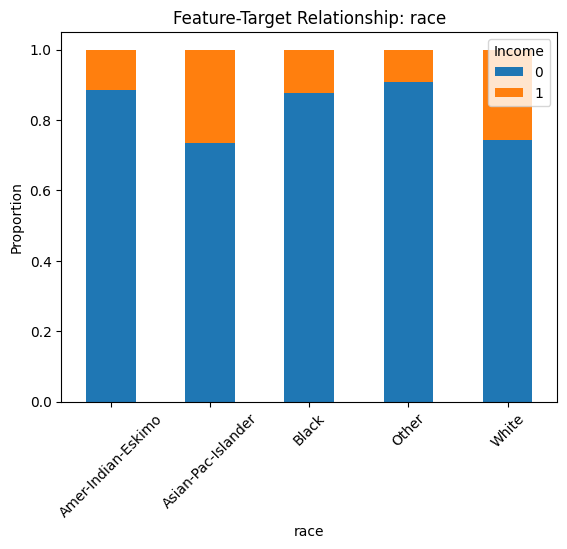

<Figure size 1000x500 with 0 Axes>

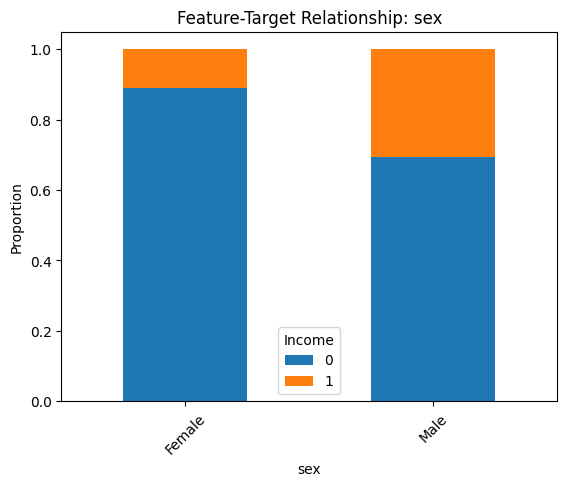

<Figure size 1000x500 with 0 Axes>

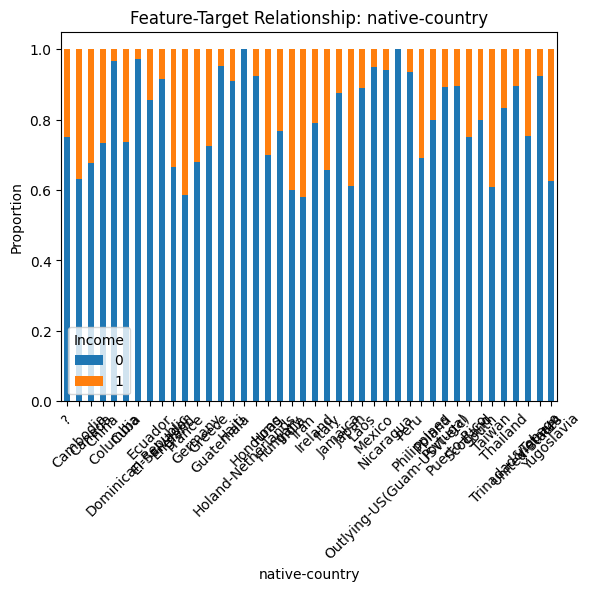

In [52]:
for col in categorical_features:
    plt.figure(figsize=(10, 5))
    # Create a crosstab of counts
    ct = pd.crosstab(df[col], df["income"], normalize='index')  # proportion per category
    ct.plot(kind='bar', stacked=True)
    plt.title(f"Feature-Target Relationship: {col}")
    plt.ylabel("Proportion")
    plt.xlabel(col)
    plt.legend(title="Income")
    plt.xticks(rotation=45)
    plt.show()
# Analyze feature-target relationships

## B2. Naïve Bayes Implementation

Implementing Naïve Bayes from scratch with mathematical formulas:

**Class Priors:**
$$P(C_k) = \frac{\text{count}(C_k) + \alpha}{\text{total samples} + \alpha \times \text{num\_classes}}$$

**Feature Likelihoods:**
$$P(x_i = v | C_k) = \frac{\text{count}(x_i = v, C_k) + \alpha}{\text{count}(C_k) + \alpha \times \text{num\_feature\_values}}$$

**Prediction:**
$$\hat{y} = \arg\max_k \left[ P(C_k) \times \prod_{i=1}^{n} P(x_i | C_k) \right]$$

In [54]:
class NaiveBayesDiscrete:
    
    def __init__(self, alpha: float = 1.0): # alpha: Smoothing parameter (Laplace smoothing)

        self.alpha = alpha
        self._classes = None
        self._priors = None
        self._likelihoods = []
        self._feature_cardinalities = []

        # Fit the Naïve Bayes model using training data.
    def fit(self, X: np.ndarray, y: np.ndarray):

        # X: Training features of shape (n_samples, n_features)
        # y: Training labels of shape (n_samples,)
        
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        
        class_counts = np.zeros(n_classes, dtype=np.float64)
        self._likelihoods = []
        self._feature_cardinalities = []
        
        # Count samples per class
        for idx, c in enumerate(self._classes):
            class_counts[idx] = np.sum(y == c)
        
        # Calculate class priors with smoothing
        self._priors = (class_counts + self.alpha) / (n_samples + self.alpha * n_classes)
        
        # Calculate feature likelihoods for each feature
        for j in range(n_features):
            # Get unique values for this feature
            feature_values = np.unique(X[:, j])
            n_values = len(feature_values)
            self._feature_cardinalities.append(n_values)
            
            # Count occurrences of each value per class
            counts = np.zeros((n_classes, n_values), dtype=np.float64)
            for idx, c in enumerate(self._classes):
                X_c = X[y == c, j]
                for v_idx, v in enumerate(feature_values):
                    counts[idx, v_idx] = np.sum(X_c == v)
            
            # Apply Laplace smoothing
            likelihoods = (counts + self.alpha) / (class_counts[:, None] + self.alpha * n_values)
            self._likelihoods.append((feature_values, likelihoods))
        
        return self
        #Predict class for a single sample.
    def _predict_single(self, x: np.ndarray) -> int:

        # x: Single sample features
        posteriors = []
        
        for idx, c in enumerate(self._classes):
            # Start with log prior
            posterior = np.log(self._priors[idx])
            
            # Add log likelihoods for each feature
            for j, (feature_values, likelihoods) in enumerate(self._likelihoods):
                # Find the value index
                value_idx = np.where(feature_values == x[j])[0]
                if len(value_idx) > 0:
                    posterior += np.log(likelihoods[idx, value_idx[0]])
                else:
                    # Unseen value, use smoothing
                    posterior += np.log(self.alpha / (np.sum(y == c) + self.alpha * len(feature_values)))
            
            posteriors.append(posterior)
        
        return self._classes[np.argmax(posteriors)]
    # Predict class labels for samples
    def predict(self, X: np.ndarray) -> np.ndarray:

        # X: Features of shape (n_samples, n_features)
        return np.array([self._predict_single(x) for x in X])
    
    # Predict class probabilities for samples
    def predict_proba(self, X: np.ndarray) -> np.ndarray:

        # X: Features of shape (n_samples, n_features)

        n_samples = X.shape[0]
        n_classes = len(self._classes)
        probs = np.zeros((n_samples, n_classes))
        
        for i, x in enumerate(X):
            log_probs = []
            for idx, c in enumerate(self._classes):
                log_prob = np.log(self._priors[idx])
                for j, (feature_values, likelihoods) in enumerate(self._likelihoods):
                    value_idx = np.where(feature_values == x[j])[0]
                    if len(value_idx) > 0:
                        log_prob += np.log(likelihoods[idx, value_idx[0]])
                    else:
                        log_prob += np.log(self.alpha / (1 + self.alpha * len(feature_values)))
                log_probs.append(log_prob)
            
            # Convert log probabilities to probabilities
            log_probs = np.array(log_probs)
            log_probs -= np.max(log_probs)  # For numerical stability
            probs[i] = np.exp(log_probs)
            probs[i] /= np.sum(probs[i])
        
        return probs

## B3. Analysis and Evaluation

### Smoothing Parameter Analysis
Testing different α values to find optimal smoothing parameter

In [55]:
from sklearn.metrics import accuracy_score

# Train with different smoothing parameter α values
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
results = []
for alpha in alphas:
    # Train model with current alpha
    nb = NaiveBayesDiscrete(alpha=alpha)
    nb.fit(X_train, y_train)
    
    # Evaluate on validation and test sets
    y_val_pred = nb.predict(X_val)
    y_train_pred = nb.predict(X_train)
    
    acc_val = accuracy_score(y_val, y_val_pred)
    acc_train = accuracy_score(y_train, y_train_pred)
    
    results.append({"alpha": alpha, "val_acc": acc_val, "train_acc": acc_train})
    print(f"α = {alpha:5.1f} | Val Acc: {acc_val:.4f} | train Acc: {acc_train:.4f}")

# Display results as DataFrame
results_df = pd.DataFrame(results)

α =   0.1 | Val Acc: 0.7963 | train Acc: 0.7930
α =   0.5 | Val Acc: 0.7965 | train Acc: 0.7929
α =   1.0 | Val Acc: 0.7963 | train Acc: 0.7927
α =   2.0 | Val Acc: 0.7965 | train Acc: 0.7925
α =   5.0 | Val Acc: 0.7944 | train Acc: 0.7913


In [56]:
# Select best alpha and analyze probability distribution
best = max(results, key=lambda r: r["val_acc"]) 
best_alpha = best["alpha"]

print(f"Best smoothing parameter: α = {best_alpha}")
print(f"Best validation accuracy: {best['val_acc']:.4f}")
print("="*50)

Best smoothing parameter: α = 0.5
Best validation accuracy: 0.7965


In [58]:

# Train model with best alpha
nb_best = NaiveBayesDiscrete(alpha=best_alpha)
nb_best.fit(X_train, y_train)
print("accuracy on testing set:", accuracy_score(y_test, nb_best.predict(X_test)))

accuracy on testing set: 0.7957011258955988


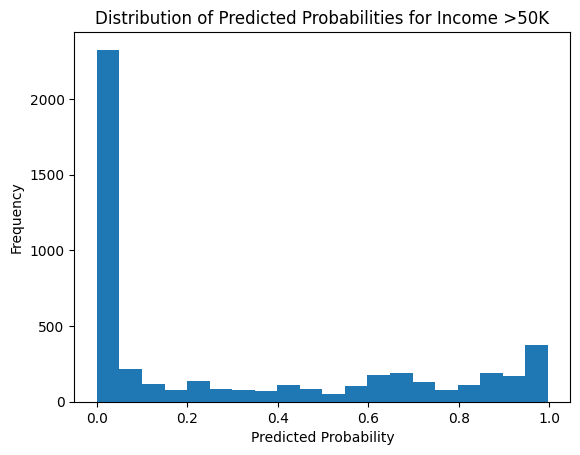

In [60]:
probs = nb_best.predict_proba(X_test)
class1_probs = probs[:, 1]   # Probability of >50K

plt.hist(class1_probs, bins=20)
plt.title("Distribution of Predicted Probabilities for Income >50K")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()


The model is very confident that most people belong to ≤50K class.

This matches the dataset: around 75% of the samples are ≤50K.

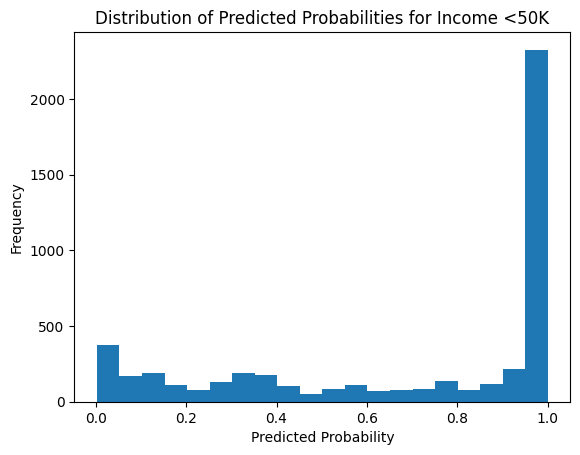

In [ ]:
probs = nb_best.predict_proba(X_test)
class2_probs = probs[:, 0]  

plt.hist(class2_probs, bins=20)
plt.title("Distribution of Predicted Probabilities for Income <50K")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()


### Feature Selection Analysis
Testing different feature subsets to understand feature importance

In [63]:
# Test different feature subsets
from sklearn.metrics import accuracy_score

feature_subsets = [
    categorical_features,
    ["marital-status", "education", "relationship","occupation"],
    ["native-country","race","workclass","sex"],
    ["workclass", "education", "marital-status"]
]

print("Feature Subset Analysis")
print("="*70)

subset_results = []
for subset in feature_subsets:
    # Create subset data
    X_sub = encoded_X[subset].values
    # 70% train, 30% temp (stratified)
    X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(
        X_sub, y,
        test_size=0.30,
        stratify=y,
        random_state=RANDOM_STATE
    )
    # 50% val, 50% test from temp (stratified)
    X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(
        X_temp_s, y_temp_s,
        test_size=0.50,
        stratify=y_temp_s,
        random_state=RANDOM_STATE
    )

    # Train and evaluate
    nb_s = NaiveBayesDiscrete(alpha=best_alpha)
    nb_s.fit(X_train_s, y_train_s)
    
    acc_val_s = accuracy_score(y_val_s, nb_s.predict(X_val_s))
    acc_test_s = accuracy_score(y_test_s, nb_s.predict(X_test_s))
    
    subset_results.append({
        "features": ", ".join(subset),
        "n_features": len(subset),
        "val_acc": acc_val_s,
        "test_acc": acc_test_s
    })
    
    print(f"\n{len(subset)} features: {', '.join(subset)}")
    print(f"  Val Acc: {acc_val_s:.4f} | Test Acc: {acc_test_s:.4f}")

# results sorted by validation accuracy
subset_df = pd.DataFrame(subset_results).sort_values("val_acc", ascending=False)
print("\n" + "="*70)
print("Summary (sorted by validation accuracy):")
subset_df

Feature Subset Analysis

8 features: workclass, education, marital-status, occupation, relationship, race, sex, native-country
  Val Acc: 0.7965 | Test Acc: 0.7957

4 features: marital-status, education, relationship, occupation
  Val Acc: 0.8016 | Test Acc: 0.8047

4 features: native-country, race, workclass, sex
  Val Acc: 0.7645 | Test Acc: 0.7617

3 features: workclass, education, marital-status
  Val Acc: 0.8215 | Test Acc: 0.8244

Summary (sorted by validation accuracy):


,features,n_features,val_acc,test_acc
3,"workclass, education, marital-status",3,0.821458,0.824360
1,"marital-status, education, relationship, occup...",4,0.801597,0.804708
0,"workclass, education, marital-status, occupati...",8,0.796478,0.795701
2,"native-country, race, workclass, sex",4,0.764537,0.761720


### Independence Assumption Analysis
Examining violations of the conditional independence assumption

**Impact of Independence Violations:**

Despite correlations between features like education-occupation and marital-status-relationship:
- Naïve Bayes often performs well even when the independence assumption is violated
- Smoothing (α parameter) helps buffer the effects of double-counting correlated features
- The model remains computationally efficient and interpretable
- Performance metrics show the algorithm is robust to moderate dependencies

Naive Bayes relies on the conditional independence assumption, meaning each feature is assumed to contribute independently to the target prediction. In real-world datasets, this assumption is often violated, since many features are correlated. Violating the independence assumption can lead to overconfident probability estimates, double-counting of similar features, and sometimes reduced accuracy. However, Naive Bayes often still performs well because it only needs the correct class ranking, not perfectly calibrated probabilities. To reduce the impact of dependence, correlated features can be removed, combined (e.g., using PCA), or replaced with models that explicitly capture dependencies.

### Performance Comparison

Compare with sklearn's MultinomialNB

In [67]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions
our_train_pred = nb_best.predict(X_train)
our_val_pred = nb_best.predict(X_val)
our_test_pred = nb_best.predict(X_test)

sk_train_pred = sk_nb.predict(X_train)
sk_val_pred = sk_nb.predict(X_val)
sk_test_pred = sk_nb.predict(X_test)

# Helper function to compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

# Prepare dataset info
datasets = [
    ("Train", y_train, our_train_pred, sk_train_pred),
    ("Validation", y_val, our_val_pred, sk_val_pred),
    ("Test", y_test, our_test_pred, sk_test_pred)
]

metrics_data = []

# Compute metrics for all datasets
for dataset_name, y_true, our_pred, sk_pred in datasets:
    our_metrics = compute_metrics(y_true, our_pred)
    sk_metrics = compute_metrics(y_true, sk_pred)
    
    metrics_data.append({
        "Dataset": dataset_name,
        "Model": "Our Implementation",
        **our_metrics
    })
    
    metrics_data.append({
        "Dataset": dataset_name,
        "Model": "MultinomialNB",
        **sk_metrics
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Compute differences for Accuracy and F1
diffs = []
for dataset in ["Train", "Validation", "Test"]:
    our_acc = metrics_df.loc[(metrics_df["Dataset"]==dataset) & (metrics_df["Model"]=="Our Implementation"), "Accuracy"].values[0]
    sk_acc = metrics_df.loc[(metrics_df["Dataset"]==dataset) & (metrics_df["Model"]=="MultinomialNB"), "Accuracy"].values[0]
    
    our_f1 = metrics_df.loc[(metrics_df["Dataset"]==dataset) & (metrics_df["Model"]=="Our Implementation"), "F1"].values[0]
    sk_f1 = metrics_df.loc[(metrics_df["Dataset"]==dataset) & (metrics_df["Model"]=="MultinomialNB"), "F1"].values[0]
    
    diffs.append({"Dataset": dataset, "Accuracy Diff": our_acc - sk_acc, "F1 Diff": our_f1 - sk_f1})

diffs_df = pd.DataFrame(diffs)

# Display results
pd.set_option("display.float_format", "{:.4f}".format)
print("=== Metrics for Train, Validation, and Test ===")
print(metrics_df)

print("\n=== Differences (Our Model - MultinomialNB) ===")
print(diffs_df)

# Final summary for Test set
our_test_acc = metrics_df.loc[(metrics_df["Dataset"]=="Test") & (metrics_df["Model"]=="Our Implementation"), "Accuracy"].values[0]
sk_test_acc = metrics_df.loc[(metrics_df["Dataset"]=="Test") & (metrics_df["Model"]=="MultinomialNB"), "Accuracy"].values[0]

print("\n=== Final Test Summary ===")
print(f"Our Implementation Accuracy: {our_test_acc:.4f}")
print(f"MultinomialNB Accuracy: {sk_test_acc:.4f}")
print(f"Difference: {our_test_acc - sk_test_acc:+.4f}")


=== Metrics for Train, Validation, and Test ===
      Dataset               Model  Accuracy  Precision  Recall     F1
0       Train  Our Implementation    0.7929     0.5533  0.7275 0.6285
1       Train       MultinomialNB    0.7453     0.4681  0.4236 0.4447
2  Validation  Our Implementation    0.7965     0.5578  0.7466 0.6385
3  Validation       MultinomialNB    0.7467     0.4716  0.4303 0.4500
4        Test  Our Implementation    0.7957     0.5568  0.7423 0.6363
5        Test       MultinomialNB    0.7410     0.4588  0.4209 0.4390

=== Differences (Our Model - MultinomialNB) ===
      Dataset  Accuracy Diff  F1 Diff
0       Train         0.0476   0.1838
1  Validation         0.0498   0.1886
2        Test         0.0547   0.1973

=== Final Test Summary ===
Our Implementation Accuracy: 0.7957
MultinomialNB Accuracy: 0.7410
Difference: +0.0547
